<a href="https://colab.research.google.com/github/manojmandal27/prompting/blob/main/OpenAI_Prompting_SPAM_HAM_Prompt_code_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Load the dataset

#Write a python code to get the kaggle data from URL known
!kaggle datasets download -d uciml/sms-spam-collection-dataset
# Unzip the downloaded dataset
!unzip sms-spam-collection-dataset.zip

# The dataset is in a .csv file format.Write a code to read the csv file
#This approach is useful when dealing with files that may have special characters or when the default encoding (usually UTF-8) does not correctly interpret the file’s content.
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
df.head()



Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 7.50MB/s]
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# prompt: drop columns Unnamed:2 , 3, 4

# Drop the unnecessary columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Rename the columns for clarity
df = df.rename(columns={'v1': 'label', 'v2': 'text'})

# Display the first few rows of the updated dataset
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:

# Basic cleaning: remove NaN, duplicates, and rename labels
df = df.dropna()
df = df.drop_duplicates()
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Text preprocessing
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()  # Remove leading and trailing spaces
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Show the first 5 samples
df.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


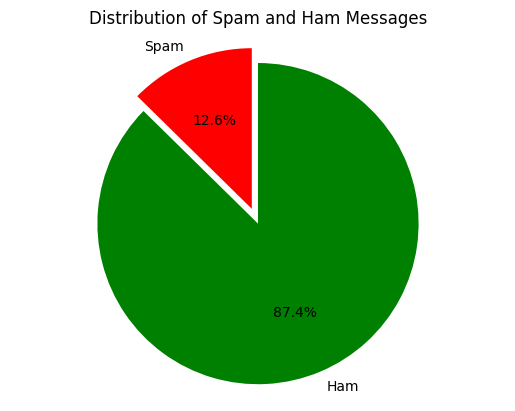

In [8]:
#  Explority data analysis
#prompt: Count the number of Spam and ham sms with pie chart

import matplotlib.pyplot as plt
# Count the number of spam and ham messages
spam_count = df['label'].value_counts()[1]
ham_count = df['label'].value_counts()[0]

# Create a pie chart
labels = ['Spam', 'Ham']
sizes = [spam_count, ham_count]
colors = ['red', 'green']
explode = (0.1, 0)  # Explode the first slice (spam)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Spam and Ham Messages')
plt.show()

In [10]:
# Define the TextVectorization layer
vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=100)
vectorizer.adapt(df['clean_text'])

# Vectorize the text data
text_vector = vectorizer(df['clean_text'])


In [11]:
# Separate spam and ham
spam_data = df[df['label'] == 1]
ham_data = df[df['label'] == 0]

# Get the most common words
spam_words = ' '.join(spam_data['clean_text']).split()
ham_words = ' '.join(ham_data['clean_text']).split()

spam_freq = pd.Series(spam_words).value_counts().head(20)
ham_freq = pd.Series(ham_words).value_counts().head(20)

print("Top 20 Spam Words:\n", spam_freq)
print("Top 20 Ham Words:\n", ham_freq)


Top 20 Spam Words:
 call       316
å          221
free       190
u          137
txt        126
text       121
ur         119
mobile     115
stop       106
claim       98
reply       95
prize       82
get         69
new         64
service     64
p           63
tone        62
urgent      58
nokia       57
send        57
Name: count, dtype: int64
Top 20 Ham Words:
 u       941
im      436
get     308
go      267
ltgt    254
ok      246
dont    242
know    229
got     226
come    223
like    222
time    206
good    206
ill     205
day     197
ur      197
call    193
want    179
love    174
need    167
Name: count, dtype: int64


In [12]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(text_vector.numpy(), df['label'], test_size=0.3, random_state=42) # Convert text_vector to a NumPy array using .numpy()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# Define the model
embedding_dim = 16
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=100),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8763 - loss: 0.4136 - val_accuracy: 0.8426 - val_loss: 0.4285
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8777 - loss: 0.3547 - val_accuracy: 0.8426 - val_loss: 0.4244
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8752 - loss: 0.3569 - val_accuracy: 0.8426 - val_loss: 0.4163
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8792 - loss: 0.3444 - val_accuracy: 0.8426 - val_loss: 0.4152
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8784 - loss: 0.3372 - val_accuracy: 0.8426 - val_loss: 0.3960
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8723 - loss: 0.3349 - val_accuracy: 0.8426 - val_loss: 0.3778
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8721 - loss: 0.3159 - val_accuracy: 0.8426 - val_loss: 0.3670
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8882 - loss: 0.2560 - val_accuracy: 0.

In [15]:
# Extract embeddings after training
embedding_layer = model.layers[0]
embeddings_after = embedding_layer.get_weights()[0]

# Function to get embedding vectors for specific words
def get_embedding_vectors(words, vectorizer, embedding_layer):
    word_indices = [vectorizer.get_vocabulary().index(word) for word in words if word in vectorizer.get_vocabulary()]
    return embedding_layer.get_weights()[0][word_indices]

# Define words for analysis
spam_words_list = ['free', 'call', 'text', 'now', 'urgent', 'claim', 'won', 'collect', 'prize', 'mobile']
ham_words_list = ['love', 'need', 'know', 'time', 'want', 'come', 'make', 'think', 'thing', 'good']

# Extract embeddings for the specified words
spam_embeddings = get_embedding_vectors(spam_words_list, vectorizer, embedding_layer)
ham_embeddings = get_embedding_vectors(ham_words_list, vectorizer, embedding_layer)




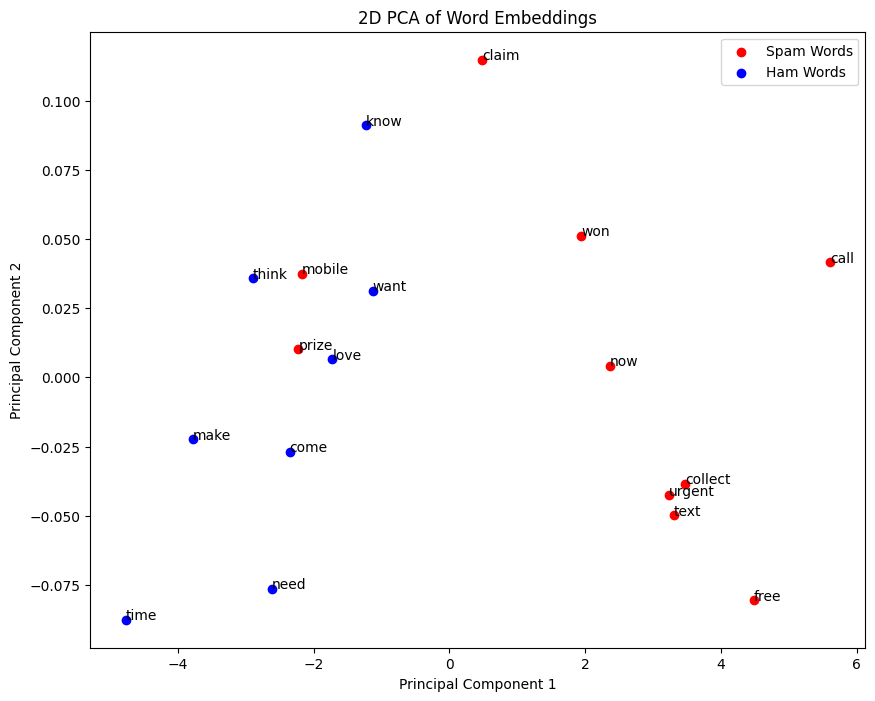

In [16]:
from sklearn.decomposition import PCA

# Combine spam and ham embeddings for PCA
combined_embeddings = np.vstack((spam_embeddings, ham_embeddings))

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:len(spam_words_list), 0], pca_result[:len(spam_words_list), 1], color='red', label='Spam Words')
plt.scatter(pca_result[len(spam_words_list):, 0], pca_result[len(spam_words_list):, 1], color='blue', label='Ham Words')

# Annotate words
for i, word in enumerate(spam_words_list + ham_words_list):
    if i < len(pca_result): #Check to ensure the index is within the bounds of pca_result
        plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

plt.title('2D PCA of Word Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [17]:
# Predict an example SMS
example_sms = "Urgent!, your won free ticket, call for free prize"
cleaned_example = clean_text(example_sms)
example_vector = vectorizer([cleaned_example])

# Predict
prediction = model.predict(example_vector)
print(f"The model predicts this SMS as: {'Spam' if prediction > 0.5 else 'Ham'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
The model predicts this SMS as: Spam
